# **LoanGuard: Model Training** 🚀

## **Objective**
This notebook focuses on building and evaluating machine learning models for **loan default prediction** using Lending Club data. The goal is to create a robust model that can accurately classify borrowers into **"Fully Paid"** and **"Charged Off"** categories, helping lenders make informed decisions.

## **Models to be Implemented**
- ✔️ **Baseline Models**: Logistic Regression, Naive Bayes, K-Nearest Neighbors (KNN)
- ✔️ **Tree-Based Models**: Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost
- ✔️ **Artificial Neural Network (ANN)**: Deep learning-based approach for capturing complex patterns
- ✔️ **Stacking Ensemble**: Combining multiple models for better predictive power

## **Expected Outcome**
By the end of this notebook, we aim to have a **high-performing loan default prediction model** that balances **accuracy, precision, and recall**, ensuring minimal false negatives (misclassified defaulters).

---

### 1. **Loading Libs**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import time
import os
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# NN
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### 2. **Load and Preprocess Data**

In [2]:
# Load train and test data
df_train = pd.read_csv('../data/processed/train.csv')
df_test = pd.read_csv('../data/processed/test.csv')

In [3]:
def encode_target(df):
    """Encode loan_status: Fully Paid -> 0, Charged Off -> 1"""
    df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
    return df

In [4]:
df_train = encode_target(df_train)
df_test = encode_target(df_test)

In [5]:
# Define features and target
X_train = df_train.drop(columns=['loan_status'])
y_train = df_train['loan_status']
X_test = df_test.drop(columns=['loan_status'])
y_test = df_test['loan_status']

In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3. Define Model Evaluation Function

#### 3.1 Traditional Model Evaluation Function

In [7]:
def evaluate_model(model_name, true, pred, train=True):
    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
    
    if train:
        print(f"{model_name} - Train Result:\n================================================")
    else:
        print(f"{model_name} - Test Result:\n================================================")
    
    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("------------------------------------------------")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("------------------------------------------------")
    print(f"Confusion Matrix: \n{confusion_matrix(true, pred)}\n")

#### 3.2 Neural Network Evaluation Function and Learning Plots

In [8]:
def evaluate_neural_network(true, pred, train=True):
    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
    
    if train:
        print("ANN - Train Result:\n================================================")
    else:
        print("ANN - Test Result:\n================================================")
    
    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("------------------------------------------------")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("------------------------------------------------")
    print(f"Confusion Matrix: \n{confusion_matrix(true, pred)}\n")

In [9]:
def plot_learning_evolution(hist):
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(hist.history['loss'], label='Training Loss', color='red', linestyle='--', marker='o')
    ax1.plot(hist.history['val_loss'], label='Validation Loss', color='red', linestyle='-', marker='s')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(hist.history['AUC'], label='Training AUC', color='blue', linestyle='--', marker='o')
    ax2.plot(hist.history['val_AUC'], label='Validation AUC', color='blue', linestyle='-', marker='s')
    ax2.set_ylabel("AUC Score", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc="upper right")

    plt.title("Model Training Performance (Loss & AUC)")
    plt.show()

In [10]:
num_columns = X_train.shape[1]
num_labels = 1

def nn_model(hp):
    input_dim = num_columns
    inp = tf.keras.layers.Input(shape=(input_dim,))
    x = BatchNormalization()(inp)
    x = Dropout(hp.Float('dropout_1', 0.0, 0.5, step=0.1))(x)
    
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=32), activation='relu', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float(f'dropout_{i+2}', 0.0, 0.5, step=0.1))(x)
    
    output_activation = 'sigmoid' if num_labels == 1 else 'softmax'
    x = Dense(num_labels, activation=output_activation, dtype="float32")(x)
    
    model = Model(inputs=inp, outputs=x)
    optimizer = Adam(hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='AUC')])
    
    return model

### 4. Model training

In [11]:
# Dictionary to store scores
scores_dict = {}
model_results = {}

#### 4.1 Traditional Models

In [12]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": LGBMClassifier(device="gpu"),
    "CatBoost": CatBoostClassifier(task_type="GPU", verbose=0)
}

- Hyperparameter Tuning

In [13]:
# Define hyperparameter grids for key models
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 9],
        "n_estimators": [100, 200, 300],
    },
    "LightGBM": {
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [31, 50, 100],
        "n_estimators": [100, 200, 300],
    }
}

In [14]:
# Perform RandomizedSearchCV for broad search
best_models = {}
for model_name, param_grid in param_grids.items():
    model = models[model_name]
    random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_models[model_name] = random_search.best_estimator_
    print(f"✅ Best parameters for {model_name}: {random_search.best_params_}")

✅ Best parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': None}
✅ Best parameters for XGBoost: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
[LightGBM] [Info] Number of positive: 51958, number of negative: 212505
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2217
[LightGBM] [Info] Number of data points in the train set: 264463, number of used features: 80
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (5.04 MB) transferred to GPU in 0.008835 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196466 -> initscore=-1.408530
[LightGBM] [Info] Start training from score -1.408530
✅ Best parameters for LightGBM: {'num_leaves': 31, 'n_estimat

In [15]:
# Refining with GridSearchCV on the top performer (Optional)
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_test, best_models[name].predict_proba(X_test)[:, 1]))
grid_search = GridSearchCV(best_models[best_model_name], param_grids[best_model_name], cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"🔍 Best fine-tuned parameters for {best_model_name}: {grid_search.best_params_}")
best_models[best_model_name] = grid_search.best_estimator_

[LightGBM] [Info] Number of positive: 51958, number of negative: 212505
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2217
[LightGBM] [Info] Number of data points in the train set: 264463, number of used features: 80
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (5.04 MB) transferred to GPU in 0.008485 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196466 -> initscore=-1.408530
[LightGBM] [Info] Start training from score -1.408530
🔍 Best fine-tuned parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}


In [16]:
models.update(best_models)

In [17]:
# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")

    start_time = time.time()
    
    if name not in param_grids:
        model.fit(X_train, y_train)

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    
    # Predictions for evaluation
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate performance
    evaluate_model(name, y_train, y_train_pred.round(), train=True)
    evaluate_model(name, y_test, y_test_pred.round(), train=False)

    # Store accuracy results
    model_results[name] = accuracy_score(y_test, y_test_pred)

    # Compute and store ROC AUC Scores
    if hasattr(model, 'predict_proba'):
        train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]) * 100
        test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) * 100
    else:
        train_roc_auc = roc_auc_score(y_train, model.predict(X_train)) * 100
        test_roc_auc = roc_auc_score(y_test, y_test_pred) * 100
    
    scores_dict[name] = {
        'Train': train_roc_auc,
        'Test': test_roc_auc
    }


Training Logistic Regression...
Time taken: 263.62 seconds
Logistic Regression - Train Result:
Accuracy Score: 88.92%
------------------------------------------------
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.883365      0.943596  0.889179       0.913480       0.895198
recall          0.993224      0.463644  0.889179       0.728434       0.889179
f1-score        0.935079      0.621774  0.889179       0.778426       0.873525
support    212505.000000  51958.000000  0.889179  264463.000000  264463.000000
------------------------------------------------
Confusion Matrix: 
[[211065   1440]
 [ 27868  24090]]

Logistic Regression - Test Result:
Accuracy Score: 88.92%
------------------------------------------------
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.883839      0.939727  0.889214       0.911783       0.894758
recall          0.99279

#### 4.1 Artificial Neural Network (ANN)

In [18]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

- Hyperparameter Tuning

In [19]:
tuner = kt.RandomSearch(
    nn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='../artifacts',
    project_name='ann_tuning'
)

Reloading Tuner from ../artifacts\ann_tuning\tuner0.json


In [20]:
tuner.search(
    X_train, 
    y_train, 
    epochs=20, 
    validation_data=(X_test, y_test), 
    batch_size=32, 
    callbacks=[
        EarlyStopping(
            monitor='val_loss', 
            patience=5
        )
    ]
)

Trial 10 Complete [00h 14m 14s]
val_loss: 0.27602338790893555

Best val_loss So Far: 0.26165762543678284
Total elapsed time: 5d 00h 55m 10s


In [21]:
# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [22]:
batch_size = 256  # Larger batch for better GPU utilization

# optimized data loading
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

with tf.device('/GPU:0'):  # Force training on GPU
    history = best_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        ],
        verbose=1
    )


Epoch 1/50
1034/1034 [==============================] - 10s 9ms/step - loss: 0.3510 - AUC: 0.8386 - val_loss: 0.2705 - val_AUC: 0.8984 - lr: 6.6455e-04
Epoch 2/50
1034/1034 [==============================] - 9s 9ms/step - loss: 0.2766 - AUC: 0.8890 - val_loss: 0.2636 - val_AUC: 0.9030 - lr: 6.6455e-04
Epoch 3/50
1034/1034 [==============================] - 9s 9ms/step - loss: 0.2682 - AUC: 0.8961 - val_loss: 0.2611 - val_AUC: 0.9044 - lr: 6.6455e-04
Epoch 4/50
1034/1034 [==============================] - 9s 9ms/step - loss: 0.2644 - AUC: 0.8993 - val_loss: 0.2595 - val_AUC: 0.9050 - lr: 6.6455e-04
Epoch 5/50
1034/1034 [==============================] - 9s 9ms/step - loss: 0.2625 - AUC: 0.9011 - val_loss: 0.2586 - val_AUC: 0.9055 - lr: 6.6455e-04
Epoch 6/50
1034/1034 [==============================] - 9s 9ms/step - loss: 0.2609 - AUC: 0.9026 - val_loss: 0.2580 - val_AUC: 0.9057 - lr: 6.6455e-04
Epoch 7/50
1034/1034 [==============================] - 9s 9ms/step - loss: 0.2600 - AUC: 0.9

In [23]:
# Evaluate Model
y_train_pred = best_model.predict(X_train)
evaluate_neural_network(y_train, y_train_pred.round(), train=True)

y_test_pred = best_model.predict(X_test)
evaluate_neural_network(y_test, y_test_pred.round(), train=False)

# Compute ROC AUC Scores
scores_dict["ANN"] = {
    "Train": roc_auc_score(y_train, best_model.predict(X_train)) * 100,
    "Test": roc_auc_score(y_test, best_model.predict(X_test)) * 100,
}

model_results["ANN"] = accuracy_score(y_test, y_test_pred.round())

8265/8265 [==============================] - 11s 1ms/step
ANN - Train Result:
Accuracy Score: 89.05%
------------------------------------------------
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.883407      0.957864  0.890476       0.920635       0.898035
recall          0.995021      0.462893  0.890476       0.728957       0.890476
f1-score        0.935898      0.624158  0.890476       0.780028       0.874652
support    212505.000000  51958.000000  0.890476  264463.000000  264463.000000
------------------------------------------------
Confusion Matrix: 
[[211447   1058]
 [ 27907  24051]]

4076/4076 [==============================] - 5s 1ms/step
ANN - Test Result:
Accuracy Score: 88.97%
------------------------------------------------
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.883423      0.949425  0.889667       0.916424       0.896317

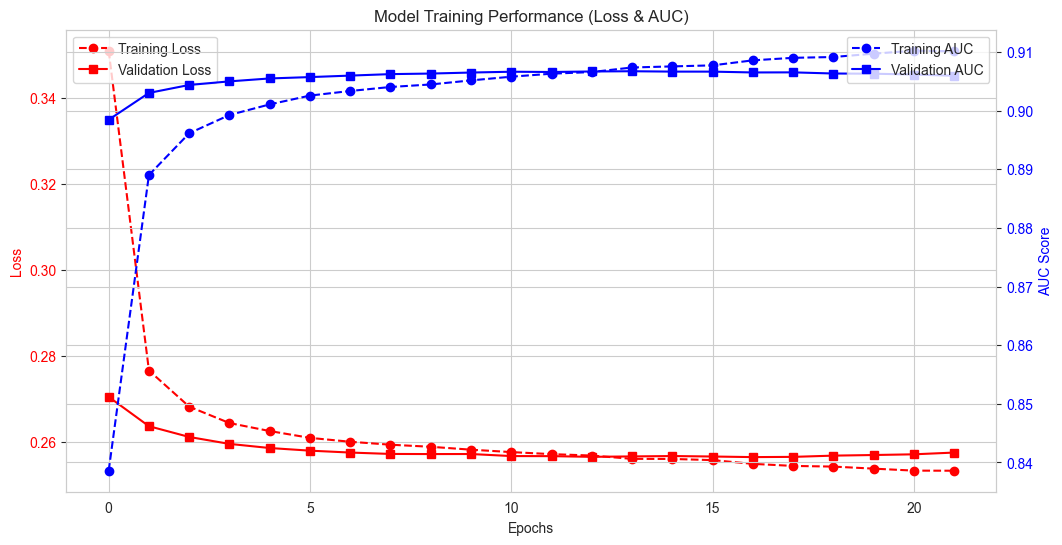

In [24]:
# Plot training progress of Artifical Neural Network
plot_learning_evolution(history)

In [25]:
scores_df = pd.DataFrame(scores_dict)
scores_df.hvplot.barh(
    width=700, height=500, 
    title="Train vs Test ROC Scores of ML Models", xlabel="ROC AUC Score (%)", 
    alpha=0.6, legend='top'
)

:Bars   [index,Variable]   (value)

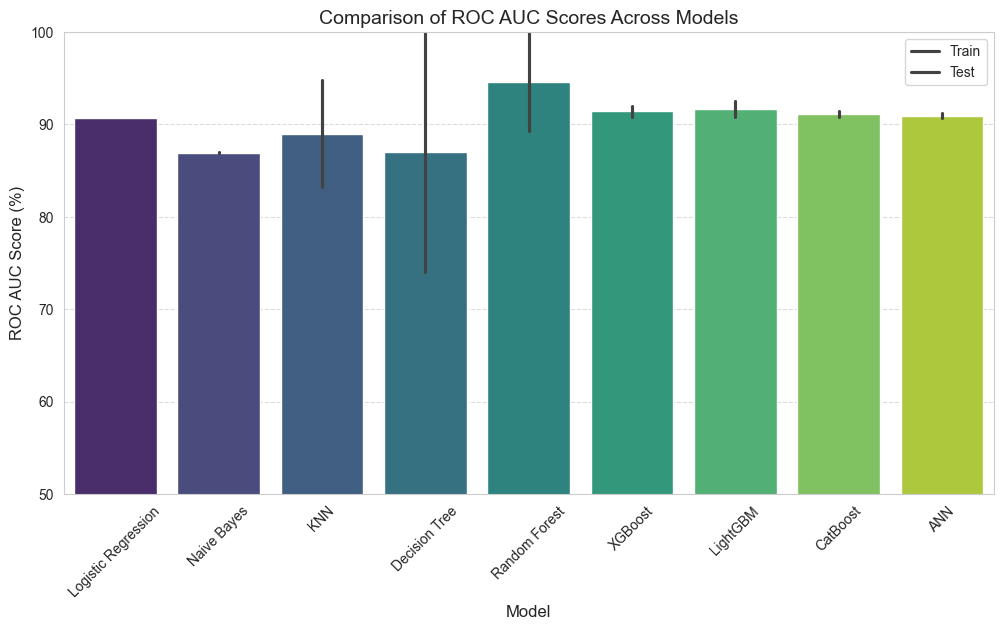

In [26]:
# Plot the ROC AUC scores
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_df, palette="viridis")
plt.title("Comparison of ROC AUC Scores Across Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("ROC AUC Score (%)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(50, 100)  # Set a reasonable range for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(["Train", "Test"])
plt.show()

### 5. Model Comparison & Selection

In [27]:
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

                 Model  Accuracy
7             CatBoost  0.889843
6             LightGBM  0.889728
8                  ANN  0.889667
5              XGBoost  0.889636
4        Random Forest  0.889582
0  Logistic Regression  0.889214
2                  KNN  0.872193
1          Naive Bayes  0.867654
3        Decision Tree  0.829271


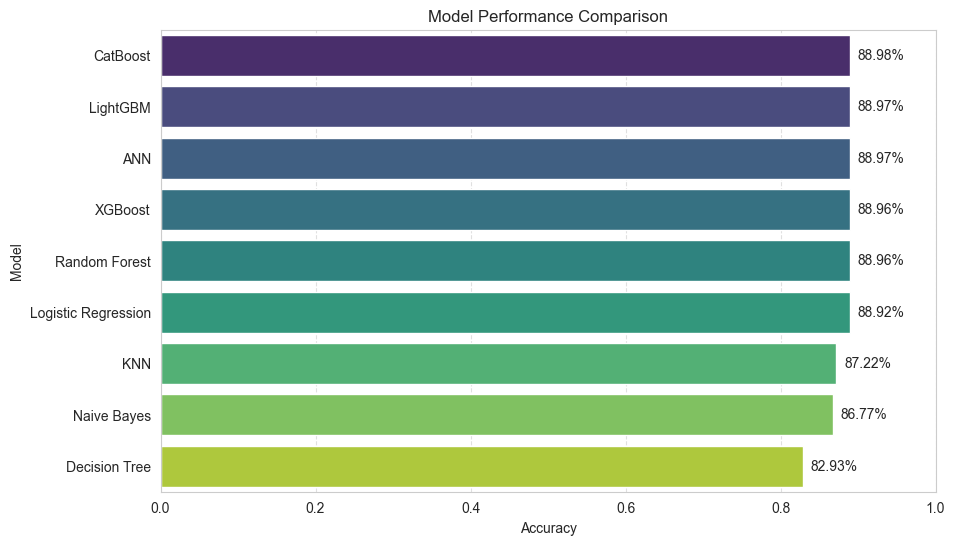

In [28]:
# 📊 Visualization of Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df["Accuracy"], y=results_df["Model"], palette="viridis", hue=results_df["Model"], legend=False)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Performance Comparison")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Display the accuracy values on the bars
for index, value in enumerate(results_df["Accuracy"]):
    plt.text(value + 0.01, index, f"{value:.2%}", va="center")

plt.show()

In [ ]:
del model_results["ANN"]

### 6. Saving the models

In [ ]:
os.makedirs("../artifacts", exist_ok=True)
for name, model in models.items():
    if name in best_models.keys(): filename = f"../artifacts/{name.replace(' ', '_')}_tuned.pkl"
    else: filename = f"../artifacts/{name.replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved tuned {name} to {filename}")

✅ Saved tuned Logistic Regression to ../artifacts/Logistic_Regression.pkl
✅ Saved tuned Naive Bayes to ../artifacts/Naive_Bayes.pkl
✅ Saved tuned KNN to ../artifacts/KNN.pkl
✅ Saved tuned Decision Tree to ../artifacts/Decision_Tree.pkl
✅ Saved tuned Random Forest to ../artifacts/Random_Forest_tuned.pkl
✅ Saved tuned XGBoost to ../artifacts/XGBoost_tuned.pkl
✅ Saved tuned LightGBM to ../artifacts/LightGBM_tuned.pkl
✅ Saved tuned CatBoost to ../artifacts/CatBoost.pkl


In [35]:
# Save ANN model in HDF5 format
os.makedirs("../artifacts", exist_ok=True)
best_model.save("../artifacts/ann_best_model.h5")
print("✅ Tuned ANN Model Saved Successfully!")

✅ Tuned ANN Model Saved Successfully!
